In [1]:
import sys
import pathlib
sys.path.append("..")

import shap
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

from src.pretraining import PretrainedTimeDRL
from scripts.utils import load_datasets, get_config
from src.linear_models import LinearClassifier

In [2]:
DATASET_NAME = "Synthetic"
MODELS_DIR = pathlib.Path("../models")

config = get_config(DATASET_NAME, "pretraining")
train_ds, _, test_ds = load_datasets(DATASET_NAME, config)

if torch.cuda.is_available(): 
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = PretrainedTimeDRL.load_from_checkpoint(
    MODELS_DIR / f"{DATASET_NAME}_pretrained.ckpt", device, strict=False
)
print(f"Using device: {model.device}")

Using device: mps:0


/opt/homebrew/anaconda3/envs/timeseries/lib/python3.9/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [3]:
train_cls, train_timesteps, train_labels = model.get_representations_from_dataloader(
    DataLoader(train_ds, batch_size=10, shuffle=False)
)

test_cls, test_timesteps, test_labels = model.get_representations_from_dataloader(
    DataLoader(test_ds, batch_size=10, shuffle=False)
)

Extracting representations from dataloader: 100%|██████████| 20/20 [00:00<00:00, 31.17batch/s]


Training LinearClassifier: 100%|██████████| 30/30 [00:03<00:00,  7.90epoch/s]


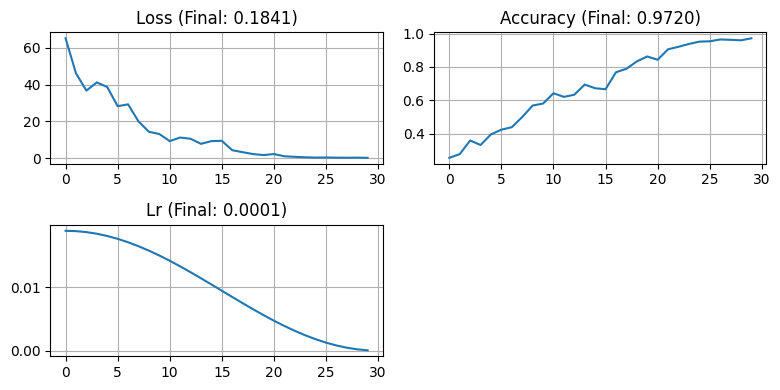

In [4]:
def plot_history(history):
    fig = plt.figure(figsize=(8, 4))
    for i, (name, data) in enumerate(history.items()):
        ax = fig.add_subplot(len(history) // 2 + 1, 2, i + 1)
        ax.plot(data)
        ax.set_title(f"{name.title().replace('_', ' ')} (Final: {data[-1]:.4f})")
        ax.grid(True)
    fig.tight_layout()
    return fig

classifier = LinearClassifier(
    dropout_rate=0.2,
    learning_rate=config["finetuning"]["learning_rate"],
    weight_decay=config["finetuning"]["weight_decay"],
    epochs=30,
    device=device,
    random_state=849213,
)
classifier.fit(train_timesteps, train_labels)

fig = plot_history(classifier.history_)

In [5]:
test_preds = classifier.predict(test_timesteps)

{
    "accuracy": accuracy_score(test_labels, test_preds),
    "macro_f1": f1_score(test_labels, test_preds, average="macro"),
    "kappa": cohen_kappa_score(test_labels, test_preds)
}

{'accuracy': 0.94,
 'macro_f1': 0.9395640734574279,
 'kappa': np.float64(0.9196733382421849)}

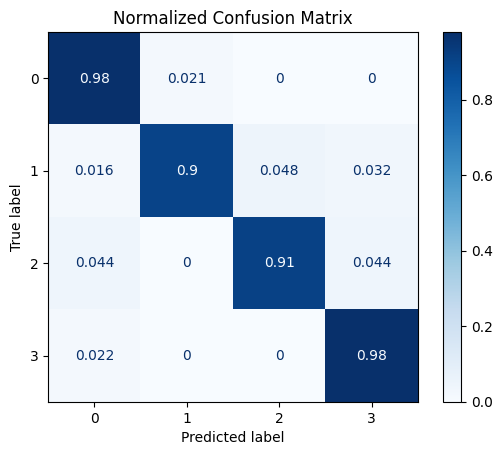

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create confusion matrix plot
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(
    test_labels, test_preds, ax=ax,
    display_labels=classifier.classes_,
    cmap='Blues', normalize='true',
)
ax.set_title('Normalized Confusion Matrix')
plt.show()


In [7]:
N, T, D = train_timesteps.shape
sequences = np.concatenate((train_timesteps, np.zeros((1, T, D))))
sample_ixs = np.column_stack([np.arange(N)] * T)

eval_count = 0

def f(sample_ix: np.ndarray):
    global eval_count
    if eval_count == 0:
        print(f"Shape of batches: {sample_ix.shape}")
    eval_count += 1
    input = sequences[sample_ix, np.arange(T)[np.newaxis, :]]
    pred = classifier.predict_proba(input)
    return pred

def masker(mask: np.ndarray, sample_ix: np.ndarray):
    masked = sample_ix.copy()
    masked[~mask] = -1
    return masked[np.newaxis, :]

explainer = shap.Explainer(f, masker)
shap_values = explainer(sample_ixs, batch_size=100)
print(f"Called classifier.predict_proba {eval_count} times")


Shape of batches: (65, 32)


PermutationExplainer explainer: 1001it [00:46, 17.32it/s]                         

Called classifier.predict_proba 7999 times


Shapley values try to measure the contribution of a feature value for a given
sample and output feature. For a multiclass linear model $f$ and a sample $x$
this can be easily calculated as: 
$$
\phi_{cj} = W_{cj} x_j - \underbrace{W_{cj} \mathbb{E}[X_j]}_\text{Mean effect estimate}
$$
where $W \in \mathbb{R}^{\text{\# of Classes} \times \text{\# of Features}}$ is
the weight matrix of the model. This is what Shapley values are trying to
estimate for more complex models the contribution of each feature value to each
output for a given sample.

The problem: how can we aggregate this information to know which features
(timesteps) are the most important.

The result of calculating the Shapley values of each timestep for every sample
in the training dataset is a tensor of shape $\text{\# of Samples} \times
\text{\# of Timesteps} \times \text{\# of Classes}$. Firstly we reduce the third
dimension ($\text{\# of Classes}$) by selecting only that vector which
corresponds to the predicted class label of that sample (we are interested in
the timestep which has the largest effect on the prediction). Doing so we get a
matrix of shape $\text{\# of Samples} \times \text{\# of Timesteps}$ where we
apply normalization to each row and average the result, hence we get the
importance values of each timestep.

In [8]:
from scipy.stats import norm

time = np.linspace(0, 4 * np.pi, 500)
interference_times = torch.load(
    "../datasets/classification/Synthetic/train.pt", weights_only=False
)["interference_times"]
importance_by_interference = np.array([
    np.array([norm.pdf(time, loc=t) for t in channel_]).max(axis=0)
    for channel_ in interference_times
])

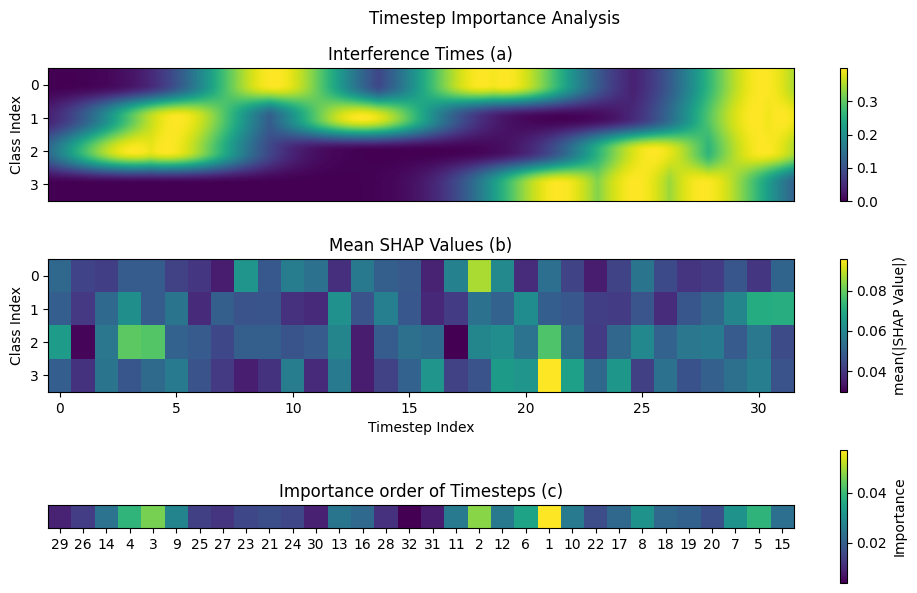

In [9]:
mean_shap = np.mean(np.abs(shap_values.values), axis=0)

train_preds = classifier.predict(train_timesteps)
importance = np.transpose(shap_values.values, (0, 2, 1))[
    np.arange(len(train_preds)), train_preds
]
importance = importance.mean(axis=0)
# importance = (
    # (importance - importance.mean(axis=1, keepdims=True))
    # / importance.std(axis=1, keepdims=True)
# ).mean(axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6))
fig.suptitle("Timestep Importance Analysis")

# Plot importance by interference
im1 = ax1.imshow(importance_by_interference, aspect="auto")
ax1.set_title("Interference Times (a)")
ax1.set_xticks([])
ax1.set_ylabel("Class Index")
fig.colorbar(im1, ax=ax1, label="")

# Plot mean SHAP values
im2 = ax2.imshow(mean_shap.T, aspect="auto")
ax2.set_title("Mean SHAP Values (b)")
ax2.set_ylabel("Class Index")
ax2.set_xlabel("Timestep Index")
fig.colorbar(im2, ax=ax2, label="mean(|SHAP Value|)")

im3 = ax3.imshow(importance.reshape(1, -1))
ax3.set_title("Importance order of Timesteps (c)")
ax3.set_xticks(np.argsort(importance)[::-1], range(1, T+1))
ax3.set_yticks([])
fig.colorbar(im3, ax=ax3, label="Importance")

plt.tight_layout()
plt.show()

- **(a)** Visualization of the interference times for each class. These indicate
the specific timesteps where the underlying signal differs between classes,
serving as the true discriminative features in the synthetic dataset.
- **(b)** Heatmap of the mean absolute SHAP values for each class across all
timesteps. This plot highlights which timesteps are most influential for the
model's predictions for each class, as determined by the SHAP explainability
method.
- **(c)** The overall importance of each timestep, computed by
aggregating SHAP values as described above. The labels on the x axis show the
importance order for the timesteps going from most important (1) to least
important. 

In [10]:
from tqdm import tqdm
from src.masking import mask_timesteps

# order = np.argsort((avg_shap_magnitudes / avg_shap_magnitudes.sum(axis=0)).max(axis=1))
order = np.argsort(importance)
print(f"Importance order of timesteps: {order.tolist()}")

accuracy_random = []
accuracy_shap = []

masked_percentages = np.linspace(0, 0.9, 10)  # 10 steps from 0 to 0.9
for prob in tqdm(masked_percentages, desc="Evaluating masked percentages"):
    masked_count = int(len(order) * (prob))

    # SHAP-based masking
    if masked_count != 0:
        masked_ixs = order[:masked_count]
        timesteps_shap = mask_timesteps(test_timesteps, masked_ixs)
    else:
       timesteps_shap = test_timesteps
    preds_shap = classifier.predict(timesteps_shap)
    accuracy_shap.append(accuracy_score(test_labels, preds_shap))

    # Randomly mask out the timestep features of the test samples
    random_accuracies = []
    for _ in range(15):
        masks = np.array([
            np.random.choice(np.arange(test_timesteps.shape[1]), size=masked_count, replace=False)
            for _ in range(len(test_labels))
        ])
        timesteps_random = mask_timesteps(test_timesteps, masks)
        random_preds = classifier.predict(timesteps_random)
        random_accuracies.append(accuracy_score(test_labels, random_preds))

    accuracy_random.append(np.array(random_accuracies).mean())


Importance order of timesteps: [15, 16, 11, 0, 14, 7, 1, 6, 10, 8, 23, 9, 28, 27, 26, 24, 13, 31, 2, 12, 19, 17, 22, 5, 25, 29, 20, 30, 3, 4, 18, 21]


Evaluating masked percentages: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s]


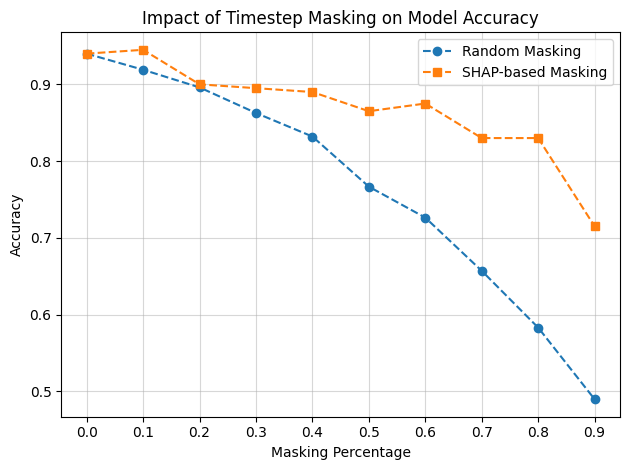

In [11]:
plt.figure()
plt.plot(masked_percentages, accuracy_random, marker='o', linestyle='--', label="Random Masking")
plt.plot(masked_percentages, accuracy_shap, marker='s', linestyle='--', label="SHAP-based Masking")

plt.title("Impact of Timestep Masking on Model Accuracy")
plt.xlabel("Masking Percentage")
plt.ylabel("Accuracy")
plt.xticks(np.linspace(0, 0.9, 10))
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()